# Linear Regression Model 2.1 (LR2.1)
With reservoir dynamics but only reaches within 50 km downstream of a dam

## Data Processing

In [1]:
import sys
import geemap
import ee
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import os
from pathlib import Path
import time
from random import randint
import json


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, ShuffleSplit, RepeatedKFold, train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# import tensorflow as tf
import HydroErr as he

import pickle

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
proj_dir = Path("../../..")

In [3]:
utils = str(proj_dir / 'utils')
sys.path.insert(0, utils)
from sql import connect # utility functions for connecting to MySQL

In [4]:
# Create a connection object to the MySQL database
# conn = connect.Connect(str(proj_dir / "Methods/2.Data/DBManagement/mysql_config.ini"))
conn = connect.Connect(str(proj_dir / ".env/mysql_config.ini"))
connection = conn.conn

Connecting to MySQL database...
Connection established.


In [5]:
reaches_and_dams = pd.read_csv(proj_dir / "Methods/machine_learning/ML2/reaches_and_dams.csv")

In [6]:
reaches_of_interest = ["Columbia_River_59","Willamette_River_15", "Kootenay_River_47", "Okanogan_River_29"]
# also test for Willamette_River_16, Kootenay_River_47, 

In [7]:
# query = f"""
# SELECT 
#     STR_TO_DATE(CONCAT(Year,
#                     '-',
#                     LPAD(Month, 2, '00'),
#                     '-',
#                     LPAD(DayOfMonth, 2, '00')),
#             '%Y-%m-%d') AS Date,
#     Month,
#     DayOfMonth,
#     ROUND(WaterTemp, 2) as WaterTemp,
#     ROUND(LandTemp, 2) as LandTemp,
#     ROUND(NDVI, 2) as NDVI,
#     ClimateClass,
#     --     ROUND(((watertemp - WaterTemperature) / WaterTemperature),
#     --             2) AS PercentDeviation,
#     --     ROUND((watertemp - WaterTemperature), 2) AS Deviation,
#     Width,
#     ReachID,
#     ReachName,
#     ROUND(InsituTemp, 2) AS InsituTemp
# FROM
#     (SELECT 
#         IF(DAY(ReachLandsatWaterTemp.date) < 15, 1, 15) AS DayOfMonth,
#             MONTH(ReachLandsatWaterTemp.date) AS Month,
#             YEAR(ReachLandsatWaterTemp.date) AS Year,
#             AVG(ReachLandsatWaterTemp.Value) AS WaterTemp,
#             AVG(ReachLandsatLandTemp.Value) AS LandTemp,
#             AVG(ReachNDVI.Value) AS NDVI,
#             IFNULL(Reaches.WidthMean, 30) AS Width,
#             Reaches.ClimateClass AS ClimateClass,
#             ReachLandsatWaterTemp.ReachID AS ReachID,
#             Reaches.Name AS ReachName
#     FROM
#         ReachLandsatWaterTemp
#     INNER JOIN ReachLandsatLandTemp USING (date , ReachID)
#     INNER JOIN ReachNDVI USING (date , ReachID)
#     INNER JOIN Reaches USING (ReachID)
#     -- WHERE
#     --    Reaches.Name NOT IN {tuple(reaches_of_interest)}
#     --        AND ReachLandsatWaterTemp.Value > 0
#     GROUP BY DayOfMonth , Month , Year , ClimateClass , ReachID , Width) AS T
#     --         INNER JOIN
#     --     ReachLandsatLTMSemiMonthly USING (DayOfMonth , Month , ReachID)
#         LEFT JOIN
#     (SELECT 
#         IF(DAY(ReachInsituWaterTemp.date) < 15, 1, 15) AS DayOfMonth,
#             MONTH(ReachInsituWaterTemp.date) AS Month,
#             YEAR(ReachInsituWaterTemp.date) AS Year,
#             AVG(ReachInsituWaterTemp.Value) AS InsituTemp,
#             ReachInsituWaterTemp.ReachID AS ReachID
#     FROM
#         ReachInsituWaterTemp
#     INNER JOIN Reaches USING (ReachID)
#     WHERE
#         ReachInsituWaterTemp.Value > 0
#     GROUP BY DayOfMonth , Month , Year , ReachID) AS I USING (DayOfMonth , Month , Year , ReachID)
# -- ORDER BY RAND();
# """ 
# # print(query)

# df = conn.query_with_fetchmany(query, chunksize=100)

# df.to_csv(proj_dir / "Methods/2.Data/ML_input_data.csv", index=False)

df = pd.read_csv(proj_dir / "Methods/2.Data/ML_input_data.csv")

In [8]:
# df = pd.concat([chunk for chunk in data], ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear

dels = pd.read_csv(proj_dir / "Methods/3.WaterTempEst/rat_dels.csv")
dels["Date"] = pd.to_datetime(dels["Date"])
sarea = pd.read_csv(proj_dir / "Methods/3.WaterTempEst/rat_sarea.csv")
sarea["Date"] = pd.to_datetime(sarea["Date"])

In [9]:
df = df.merge(reaches_and_dams, on="ReachName", how="left")
df = df.merge(dels, on=["GranD_ID", "Date"], how="left")
df = df.merge(sarea, on=["GranD_ID", "Date"], how="left")

df.rename(columns={"dS (m3)": "dels", "area (km2)": "sarea", "Within_n*10km": "rel_dist"}, inplace=True)

original_cols = df.columns
# df.head()

In [10]:
# Scalers
# load scalers and model
with open(proj_dir / f"Results/2.WaterTempEst/scalers.pkl", "rb") as f:
    scalers = pickle.load(f)

    dayofmonth_scaler = scalers["dayofmonth_scaler"]
    month_scaler = scalers["month_scaler"]
    watertemp_scaler =  scalers["watertemp_scaler"]
    landtemp_scaler = scalers["landtemp_scaler"]
    width_scaler = scalers["width_scaler"]
    NDVI_scaler = scalers["NDVI_scaler"]
    climate_scaler = scalers["climate_scaler"]
    dels_scaler =   scalers["dels_scaler"]
    sarea_scaler = scalers["sarea_scaler"]
    rel_dist_scaler = scalers["rel_dist_scaler"]

# # define scalers
# dayofmonth_scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.DataFrame({'DayOfMonth': range(1, 15+1)}))
# month_scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.DataFrame({'Month': range(1, 12+1)}))
# watertemp_scaler = StandardScaler().fit(df[['WaterTemp']])
# landtemp_scaler = StandardScaler().fit(df[['LandTemp']])
# # watertemp_scaler = MinMaxScaler(feature_range=(0, 1)).fit(df3[['WaterTemp']])
# # landtemp_scaler = MinMaxScaler(feature_range=(0, 1)).fit(df3[['LandTemp']])
# width_scaler = MinMaxScaler(feature_range=(0, 1)).fit(df[['Width']])
# NDVI_scaler = StandardScaler().fit(df[['NDVI']])
# # NDVI_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(df3[['NDVI']])
# climate_scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.DataFrame({'ClimateClass': range(1, 30+1)}))
# dels_scaler = MinMaxScaler(feature_range=(0, 1)).fit(df[['dels']])
# sarea_scaler = MinMaxScaler(feature_range=(0, 1)).fit(df[['sarea']])
# rel_dist_scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.DataFrame({'rel_dist': range(0, 5+1)}))

# replace missing values for dels, sarea, and rel_dist with the 0
df["dels"].fillna(0, inplace=True)
df["sarea"].fillna(0, inplace=True)
df["rel_dist"].fillna(0, inplace=True)

# Scale values
df["DayOfMonth_scaled"] = dayofmonth_scaler.transform(df[["DayOfMonth"]])
df["Month_scaled"] = month_scaler.transform(df[["Month"]])
df["LandTemp_scaled"] = landtemp_scaler.transform(df[["LandTemp"]])
df["WaterTemp_scaled"] = watertemp_scaler.transform(df[["WaterTemp"]])
df["Width_scaled"] = width_scaler.transform(df[["Width"]])
df["NDVI_scaled"] = NDVI_scaler.transform(df[["NDVI"]])
df["ClimateClass_scaled"] = climate_scaler.transform(df[["ClimateClass"]])
df["dels_scaled"] = dels_scaler.transform(df[["dels"]])
df["sarea_scaled"] = sarea_scaler.transform(df[["sarea"]])
df["rel_dist_scaled"] = rel_dist_scaler.transform(df[["rel_dist"]])

# # save the scalers
# with open(proj_dir / f"Results/2.WaterTempEst/scalers.pkl", "wb") as f:
#     pickle.dump({
#         "dayofmonth_scaler": dayofmonth_scaler,
#         "month_scaler": month_scaler,
#         "watertemp_scaler": watertemp_scaler,
#         "landtemp_scaler": landtemp_scaler,
#         "width_scaler": width_scaler,
#         "NDVI_scaler": NDVI_scaler,
#         "climate_scaler": climate_scaler,
#         "dels_scaler": dels_scaler,
#         "sarea_scaler": sarea_scaler,
#         "rel_dist_scaler": rel_dist_scaler,
#     }, f)

In [11]:
# df.head()

In [24]:
handpicked = df[
    (df["ReachName"].isin(reaches_of_interest))
    & (df["InsituTemp"].notnull())
    & (df["rel_dist"] != 0)
].copy()

# X and y to be used for model (excluding handpicked reaches of interest)
X = df[
    (~df["ReachName"].isin(reaches_of_interest))
    & (df["InsituTemp"].notnull())
    & (df["rel_dist"] != 0)
][
    [
        "DayOfMonth_scaled",
        "Month_scaled",
        "LandTemp_scaled",
        "Width_scaled",
        "NDVI_scaled",
        "ClimateClass_scaled",
        "dels_scaled",
        "sarea_scaled",
        "rel_dist_scaled",
    ]
]
y = df[
    (~df["ReachName"].isin(reaches_of_interest))
    & (df["InsituTemp"].notnull())
    & (df["rel_dist"] != 0)
]["InsituTemp"]

# dev set and test set (including handpicked reaches of interest)
dev_set, test_set = train_test_split(
    df[
        (~df["ReachName"].isin(reaches_of_interest))
        & (df["InsituTemp"].notnull())
        & (df["rel_dist"] != 0)
    ],
    test_size=0.1,
    random_state=1993,
)
test_set = pd.concat([test_set, handpicked])

X_dev = dev_set[
    [
        "DayOfMonth_scaled",
        "Month_scaled",
        "LandTemp_scaled",
        "Width_scaled",
        "NDVI_scaled",
        "ClimateClass_scaled",
        "dels_scaled",
        "sarea_scaled",
        "rel_dist_scaled",
    ]
]
y_dev = dev_set["InsituTemp"]

X_test = test_set[
    [
        "DayOfMonth_scaled",
        "Month_scaled",
        "LandTemp_scaled",
        "Width_scaled",
        "NDVI_scaled",
        "ClimateClass_scaled",
        "dels_scaled",
        "sarea_scaled",
        "rel_dist_scaled",
    ]
]
y_test = test_set["InsituTemp"]

# X and y for handpicked reaches of interest
X_handpicked = handpicked[
    [
        "DayOfMonth_scaled",
        "Month_scaled",
        "LandTemp_scaled",
        "Width_scaled",
        "NDVI_scaled",
        "ClimateClass_scaled",
        "dels_scaled",
        "sarea_scaled",
        "rel_dist_scaled",
    ]
]
y_handpicked = handpicked["InsituTemp"]

## Model Development

In [13]:
model_name = "LR2_1"

cv_splitter = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1993)
l1_ratio=[0.1, 0.3, 0.5, .6, 0.7, .8, .85, .9, .925, .95, .975, 1]

model = ElasticNetCV(l1_ratio=l1_ratio,cv=cv_splitter, random_state=0, verbose=0)
model.fit(X, y)
print(model.alpha_)
print(model.intercept_)
# print(LR1.predict([[0, 0]]))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [14]:
# print(model.mse_path_[11,1])
model_dev_mse = pd.DataFrame(columns=["l1_ratio", "alpha", "mse", "fold", "model_name"])

for i, l1_ratio in enumerate(model.l1_ratio):
    for j, alpha in enumerate(model.alphas_[i]):
        for k, mse in enumerate(model.mse_path_[i, j]):
            model_dev_mse = pd.concat(
                [
                    model_dev_mse,
                    pd.DataFrame(
                        [[l1_ratio, alpha, mse, k, model_name]],
                        columns=["l1_ratio", "alpha", "mse", "fold", "model_name"],
                    ),
                ],
                ignore_index=True,
            )

model_dev_mse.to_csv(
    proj_dir / f"Results/2.WaterTempEst/1.LinearRegression/{model_name}_dev_mse.csv",
    index=False,
)

In [15]:
# save the hyperparameters
hyperparameters = pd.DataFrame(
    {
        "hyperparameter": ["l1_ratio", "alpha"],
        "value": [model.l1_ratio_, model.alpha_],
    }
)
hyperparameters.model = model_name

hyperparameters.to_csv(proj_dir / f"Results/2.WaterTempEst/1.LinearRegression/{model_name}_hyperparameters.csv", index=False)

## Model Evaluation (Using cross-validation)

In [16]:
model_eval = pd.DataFrame(columns=["model", "fold", "rmse", "nse", "r_sqaured", "mse"])

model_final = ElasticNet(alpha=model.alpha_, l1_ratio=model.l1_ratio_)

for i, (train_index, test_index) in enumerate(cv_splitter.split(X)):
    X_train_, X_test_ = X.iloc[train_index], X.iloc[test_index]
    y_train_, y_test_ = y.iloc[train_index], y.iloc[test_index]
    model_final.fit(X_train_, y_train_)
    y_pred = model_final.predict(X_test_)
    rmse = he.rmse(simulated_array=list(y_pred), observed_array=list(y_test_))
    nse = he.nse(simulated_array=list(y_pred), observed_array=list(y_test_))
    r_squared = he.r_squared(simulated_array=list(y_pred), observed_array=list(y_test_))
    mse = he.mse(simulated_array=list(y_pred), observed_array=list(y_test_))
    model_eval = pd.concat([model_eval, pd.DataFrame([[f"{model_name}", i, rmse, nse, r_squared, mse]], columns=["model", "fold", "rmse", "nse", "r_sqaured", "mse"])], ignore_index=True)

In [17]:
model_eval.to_csv(proj_dir / f"Results/2.WaterTempEst/1.LinearRegression/{model_name}_eval.csv", index=False)

## Testing (Train with dev set and test with test set)

In [18]:
model_final.fit(X_dev, y_dev)
y_pred = model_final.predict(X_test)
rmse = he.rmse(simulated_array=list(y_pred), observed_array=list(y_test))
nse = he.nse(simulated_array=list(y_pred), observed_array=list(y_test))
r_squared = he.r_squared(simulated_array=list(y_pred), observed_array=list(y_test))
mse = he.mse(simulated_array=list(y_pred), observed_array=list(y_test))

model_test = pd.DataFrame([[f"{model_name}", rmse, nse, r_squared, mse]], columns=["model", "rmse", "nse", "r_sqaured", "mse"])
model_test.to_csv(proj_dir / f"Results/2.WaterTempEst/1.LinearRegression/{model_name}_test.csv", index=False)




In [19]:
test_set[f"{model_name}"] = y_pred
test_set.to_csv(proj_dir / f"Results/2.WaterTempEst/1.LinearRegression/{model_name}_test_set.csv", index=False)

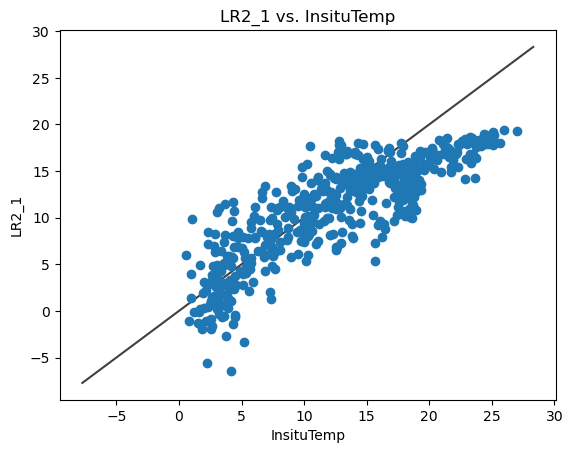

In [20]:
# plot the test model vs. insitu
fig, ax = plt.subplots()
ax.scatter(test_set["InsituTemp"], test_set[f"{model_name}"])
ax.set_xlabel("InsituTemp")
ax.set_ylabel(f"{model_name}")
ax.set_title(f"{model_name} vs. InsituTemp")

# add 1:1 line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)


# Finally, train the model with the complete dataset and store it

In [21]:
# X and y to be used for final model (excluding handpicked reaches of interest)
X_final = df[(~df["ReachName"].isin(reaches_of_interest)) & (df["InsituTemp"].notnull())][
    [
        "DayOfMonth_scaled",
        "Month_scaled",
        "LandTemp_scaled",
        "Width_scaled",
        "NDVI_scaled",
        "ClimateClass_scaled",
        "dels_scaled",
        "sarea_scaled",
        "rel_dist_scaled",
    ]
]
y_final = df[(~df["ReachName"].isin(reaches_of_interest)) & (df["InsituTemp"].notnull())]["InsituTemp"]

model_final.fit(X_final, y_final)

# save the coefficients
coefficients = pd.DataFrame(
    {
        "variable": X_final.columns.to_list() + ["intercept"],
        "coefficient": model_final.coef_.tolist() + [model_final.intercept_],
    }
)
coefficients["model"] = model_name

coefficients.to_csv(proj_dir / f"Results/2.WaterTempEst/1.LinearRegression/{model_name}_coefficients.csv", index=False)

In [22]:
# save the model
import pickle
with open(proj_dir / f"Results/2.WaterTempEst/1.LinearRegression/{model_name}_final_model.pkl", "wb") as f:
    pickle.dump(model_final, f)

# # save the scalers
# with open(proj_dir / f"Results/2.WaterTempEst/scalers.pkl", "wb") as f:
#     pickle.dump({
#         "dayofmonth_scaler": dayofmonth_scaler,
#         "month_scaler": month_scaler,
#         "watertemp_scaler": watertemp_scaler,
#         "landtemp_scaler": landtemp_scaler,
#         "width_scaler": width_scaler,
#         "NDVI_scaler": NDVI_scaler,
#         "climate_scaler": climate_scaler,
#         "dels_scaler": dels_scaler,
#         "sarea_scaler": sarea_scaler,
#         "rel_dist_scaler": rel_dist_scaler,
#     }, f)

In [23]:
# # load scalers and model
# with open(proj_dir / f"Results/2.WaterTempEst/scalers.pkl", "rb") as f:
#     scalers = pickle.load(f)

# with open(proj_dir / f"Results/2.WaterTempEst/1.LinearRegression/{model_name}_final_model.pkl", "rb") as f:
#     model_final = pickle.load(f)